In [1]:
from google.colab import drive
drive.mount('/content/drive')    # vikviken01@gmail.com

Mounted at /content/drive


In [2]:
! pip install torch torchvision numpy matplotlib pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
epochs = 20
lr = 0.0002
image_size = 128
latent_dim = 100  # Dimension du bruit
age_threshold = 30 # Filtrer le dataset pour des âges < 30

In [ ]:
# Chemin vers UTKFace
dataset_path = "/content/drive/MyDrive/utkcropped"

In [ ]:
# --- Dataset UTKFace ---
# On ne charge que les images dont l'âge est inférieur à 30.
class UTKFaceDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = [p for p in glob.glob(os.path.join(root_dir, "*.jpg"))
                            if int(os.path.basename(p).split("_")[0]) < age_threshold]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
dataset = UTKFaceDataset(dataset_path, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# --- Générateur (Generator) ---
# Architecture inspirée de DCGAN.
# L'entrée est un bruit z et une condition d'âge.
# On suppose que la condition d'âge est donnée en tant que scalaire normalisé (par exemple, 0 à 1).
# On concatène le bruit et la condition dans la dimension des canaux.

class Generator(nn.Module):
    def __init__(self, latent_dim, cond_channels=1):
        super(Generator, self).__init__()
        # L'entrée aura (latent_dim + cond_channels) canaux, entrée de forme (batch, latent_dim+1, 1, 1)
        self.net = nn.Sequential(
            # Convolution transposée pour passer de 1x1 à 4x4
            nn.ConvTranspose2d(latent_dim + cond_channels, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 4x4 -> 8x8
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 8x8 -> 16x16
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 16x16 -> 32x32
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 32x32 -> 64x64
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            # 64x64 -> 128x128
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Sortie dans [-1, 1]
        )

    def forward(self, z, age):
        # z : (batch, latent_dim)
        # age : (batch,) en format float, par exemple entre 0 et 1
        age = age.view(-1, 1)  # (batch, 1)
        # On peut simplement concaténer directement (pas besoin de transformation supplémentaire)
        # Convertir z en 4D : (batch, latent_dim, 1, 1)
        z = z.view(-1, latent_dim, 1, 1)
        # Convertir age en 4D : (batch, 1, 1, 1)
        age = age.view(-1, 1, 1, 1)
        # Concaténer sur le canal : résultat de taille (batch, latent_dim+1, 1, 1)
        input_tensor = torch.cat((z, age), dim=1)
        img = self.net(input_tensor)
        return img

In [ ]:
# --- Discriminateur (Discriminator) ---
# Le discriminateur reçoit une image (3 canaux) et une condition d'âge.
# On étend l'âge pour former un canal supplémentaire et on concatène avec l'image.
class Discriminator(nn.Module):
    def __init__(self, cond_channels=1):
        super(Discriminator, self).__init__()
        # L'entrée aura 3 + 1 = 4 canaux
        self.net = nn.Sequential(
            # 128x128 -> 64x64
            nn.Conv2d(3 + cond_channels, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0),
            # 64x64 -> 32x32
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.1),
            # 32x32 -> 16x16
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0),
            # 16x16 -> 8x8
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0),
            # 8x8 -> 4x4
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0),
            # Convolution finale pour obtenir un score par image (4x4 -> 1x1)
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, age):
        # img : (batch, 3, 128, 128)
        # age : (batch,) float, par exemple condition entre 0 et 1
        age = age.view(-1, 1, 1, 1)  # (batch, 1, 1, 1)
        # Étendre age pour correspondre à la taille de l'image (128, 128)
        age = age.expand(-1, 1, img.size(2), img.size(3))  # (batch, 1, 128, 128)
        # Concaténer l'image et l'âge pour former une entrée de 4 canaux
        input_tensor = torch.cat((img, age), dim=1)  # (batch, 4, 128, 128)
        out = self.net(input_tensor)
        # La sortie est de forme (batch, 1, 1, 1). On la réajuste en (batch, 1)
        return out.view(-1, 1)

In [ ]:
# Initialisation des modèles
generator = Generator(latent_dim=latent_dim).to(device)
discriminator = Discriminator().to(device)

In [ ]:
# Fonction de perte et optimisateurs
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
# Listes pour suivre les pertes du générateur et du discriminateur
d_losses = []
g_losses = []

In [ ]:
# Charger les modèles si disponibles
def load_checkpoint():
    checkpoint_path = "/content/drive/MyDrive/essaiconv14mars21h15_20juin25/checkpoint.pth"
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        generator.load_state_dict(checkpoint['generator_state_dict'])
        discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
        optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
        optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Reprise de l'entraînement à partir de l'époque {start_epoch}")
        return start_epoch
    else:
        print("Aucun point de contrôle trouvé, démarrage de l'entraînement à partir de zéro.")
        return 0

In [ ]:
# Sauvegarder les modèles
def save_checkpoint(epoch):
    checkpoint_path = "/content/drive/MyDrive/essaiconv14mars21h15_20juin25/checkpoint.pth"
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
    }, checkpoint_path)
    print(f"Modèle sauvegardé à l'époque {epoch}")

Aucun point de contrôle trouvé, démarrage de l'entraînement à partir de zéro.
Epoch [0/20], Batch [0/187] - D Loss: 1.3401, G Loss: 1.6799
Epoch [0/20], Batch [100/187] - D Loss: 0.4860, G Loss: 2.7575
Images sauvegardées : progress_epoch_0_conv.png


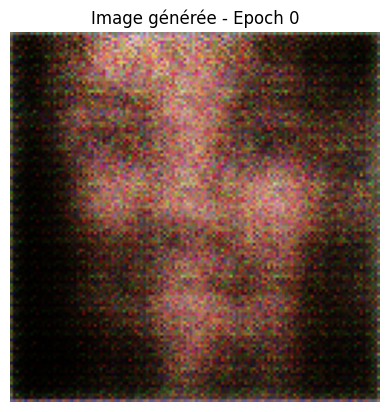

Modèle sauvegardé à l'époque 0
Epoch [1/20], Batch [0/187] - D Loss: 0.9110, G Loss: 1.3193
Epoch [1/20], Batch [100/187] - D Loss: 1.0511, G Loss: 1.6815
Modèle sauvegardé à l'époque 1
Epoch [2/20], Batch [0/187] - D Loss: 1.0170, G Loss: 1.7649
Epoch [2/20], Batch [100/187] - D Loss: 0.9982, G Loss: 2.2427
Images sauvegardées : progress_epoch_2_conv.png


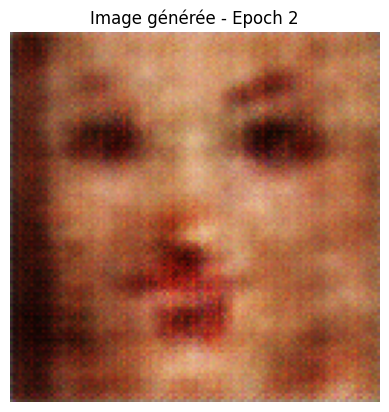

Modèle sauvegardé à l'époque 2
Epoch [3/20], Batch [0/187] - D Loss: 1.1477, G Loss: 2.6827
Epoch [3/20], Batch [100/187] - D Loss: 1.5932, G Loss: 3.1877
Modèle sauvegardé à l'époque 3
Epoch [4/20], Batch [0/187] - D Loss: 1.0943, G Loss: 2.3866
Epoch [4/20], Batch [100/187] - D Loss: 1.1995, G Loss: 1.7883
Images sauvegardées : progress_epoch_4_conv.png


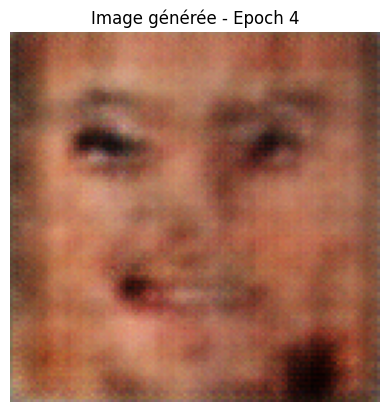

Modèle sauvegardé à l'époque 4
Epoch [5/20], Batch [0/187] - D Loss: 1.1332, G Loss: 2.0555
Epoch [5/20], Batch [100/187] - D Loss: 1.1846, G Loss: 2.5604
Modèle sauvegardé à l'époque 5
Epoch [6/20], Batch [0/187] - D Loss: 1.2477, G Loss: 0.9983
Epoch [6/20], Batch [100/187] - D Loss: 1.3312, G Loss: 1.5305
Images sauvegardées : progress_epoch_6_conv.png


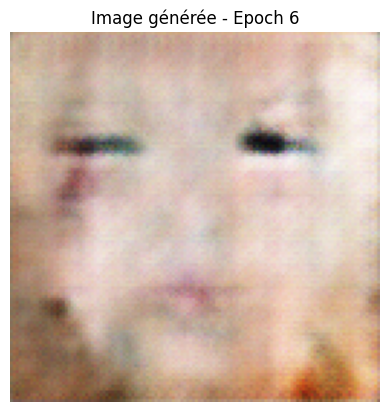

Modèle sauvegardé à l'époque 6
Epoch [7/20], Batch [0/187] - D Loss: 1.1867, G Loss: 1.8120
Epoch [7/20], Batch [100/187] - D Loss: 1.6447, G Loss: 0.7186
Modèle sauvegardé à l'époque 7
Epoch [8/20], Batch [0/187] - D Loss: 1.0576, G Loss: 1.4106
Epoch [8/20], Batch [100/187] - D Loss: 1.2533, G Loss: 1.9117
Images sauvegardées : progress_epoch_8_conv.png


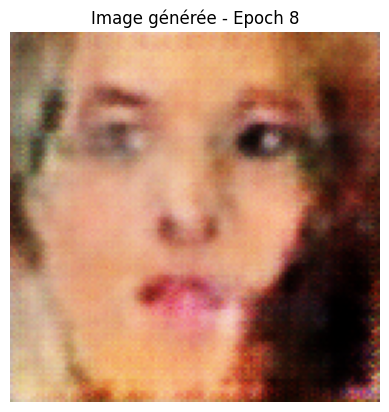

Modèle sauvegardé à l'époque 8
Epoch [9/20], Batch [0/187] - D Loss: 1.2539, G Loss: 1.6642
Epoch [9/20], Batch [100/187] - D Loss: 1.1566, G Loss: 1.9387
Modèle sauvegardé à l'époque 9
Epoch [10/20], Batch [0/187] - D Loss: 1.0759, G Loss: 1.5894
Epoch [10/20], Batch [100/187] - D Loss: 1.1621, G Loss: 1.2912
Images sauvegardées : progress_epoch_10_conv.png


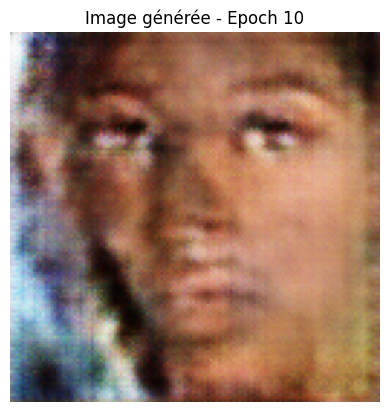

Modèle sauvegardé à l'époque 10
Epoch [11/20], Batch [0/187] - D Loss: 0.9845, G Loss: 1.4832
Epoch [11/20], Batch [100/187] - D Loss: 1.1465, G Loss: 1.3528
Modèle sauvegardé à l'époque 11
Epoch [12/20], Batch [0/187] - D Loss: 1.1177, G Loss: 1.4847
Epoch [12/20], Batch [100/187] - D Loss: 1.0417, G Loss: 1.4970
Images sauvegardées : progress_epoch_12_conv.png


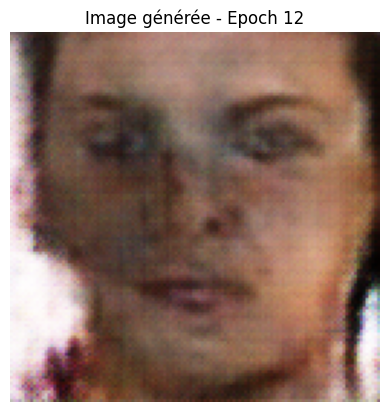

Modèle sauvegardé à l'époque 12
Epoch [13/20], Batch [0/187] - D Loss: 0.9921, G Loss: 1.5188
Epoch [13/20], Batch [100/187] - D Loss: 1.1985, G Loss: 2.0798
Modèle sauvegardé à l'époque 13
Epoch [14/20], Batch [0/187] - D Loss: 0.9731, G Loss: 1.7409
Epoch [14/20], Batch [100/187] - D Loss: 0.9763, G Loss: 1.4629
Images sauvegardées : progress_epoch_14_conv.png


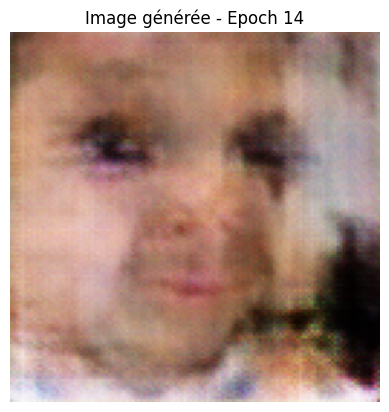

Modèle sauvegardé à l'époque 14
Epoch [15/20], Batch [0/187] - D Loss: 1.0186, G Loss: 1.2306
Epoch [15/20], Batch [100/187] - D Loss: 1.1460, G Loss: 1.1089
Modèle sauvegardé à l'époque 15
Epoch [16/20], Batch [0/187] - D Loss: 1.1409, G Loss: 2.3362
Epoch [16/20], Batch [100/187] - D Loss: 0.9486, G Loss: 1.6609
Images sauvegardées : progress_epoch_16_conv.png


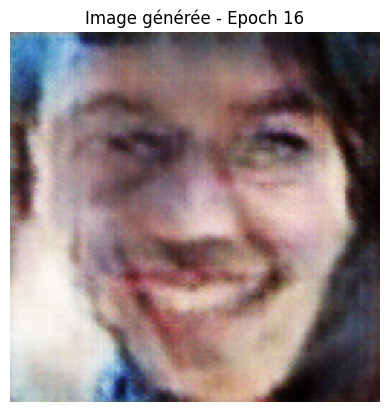

Modèle sauvegardé à l'époque 16
Epoch [17/20], Batch [0/187] - D Loss: 1.0388, G Loss: 1.5327
Epoch [17/20], Batch [100/187] - D Loss: 1.2072, G Loss: 1.1055
Modèle sauvegardé à l'époque 17
Epoch [18/20], Batch [0/187] - D Loss: 1.2695, G Loss: 2.2608
Epoch [18/20], Batch [100/187] - D Loss: 1.0560, G Loss: 1.6120
Images sauvegardées : progress_epoch_18_conv.png


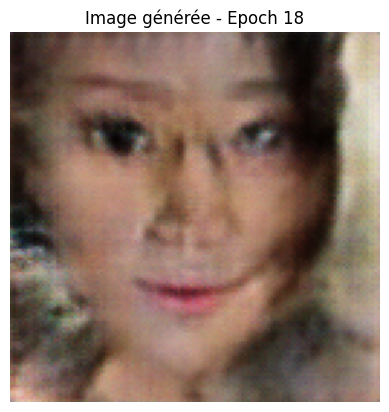

Modèle sauvegardé à l'époque 18
Epoch [19/20], Batch [0/187] - D Loss: 0.9666, G Loss: 1.8995
Epoch [19/20], Batch [100/187] - D Loss: 1.0678, G Loss: 0.8773
Images sauvegardées : progress_epoch_19_conv.png


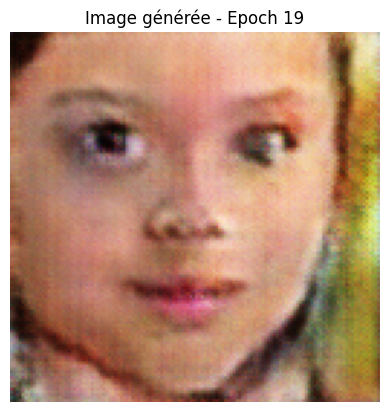

Modèle sauvegardé à l'époque 19


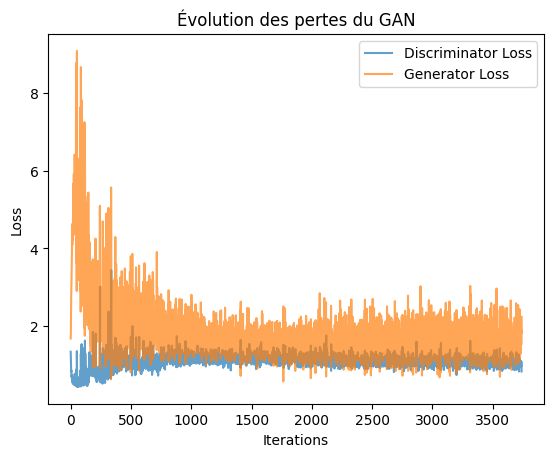

Entraînement terminé !


In [ ]:
# --- Entraînement du Conditional GAN ---
start_epoch = load_checkpoint()
for epoch in range(start_epoch, epochs):
    for i, imgs in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        real_labels = torch.full((batch_size, 1), 0.95, device=device)
        fake_labels = torch.full((batch_size, 1), 0.05, device=device)

        target_ages = torch.randint(40, 101, (batch_size,), device=device).float() / 100.0

        real_imgs = real_imgs + 0.02 * torch.randn_like(real_imgs)  # bruit à 0 ancienne valeur à 0.02
        real_imgs = torch.clamp(real_imgs, -1, 1)

        z = torch.randn(batch_size, latent_dim, device=device)
        fake_imgs = generator(z, target_ages)
        real_loss = criterion(discriminator(real_imgs, target_ages), fake_labels)
        fake_loss = criterion(discriminator(fake_imgs.detach(), target_ages), fake_labels)
        d_loss = real_loss + fake_loss

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        g_loss = criterion(discriminator(fake_imgs, target_ages), real_labels)
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        # Stocker les pertes pour analyse
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

        # **Afficher la progression toutes les 100 itérations**
        if i % 100 == 0:
            print(f"Epoch [{epoch}/{epochs}], Batch [{i}/{len(dataloader)}] - "
                  f"D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")

            # **Détection de l'effondrement du GAN**
            if d_loss.item() < 0.1:
                print("Attention : le discriminateur devient trop fort ! Ajuste le learning rate ou ajoute du bruit.")

    # **Sauvegarde et affichage des images générées tous les 10 epochs**
    if epoch % 2 == 0 or epoch == 19:
        save_image(fake_imgs[:25], f"/content/drive/MyDrive/essaiconv14mars21h15_20juin25/progress_epoch_{epoch}_conv.png", nrow=5, normalize=True)
        print(f"Images sauvegardées : progress_epoch_{epoch}_conv.png")

         # **Afficher une image générée**
        img = fake_imgs[0].cpu().detach().numpy()  # Convertir en numpy
        img = np.transpose(img, (1, 2, 0))  # Repasser en format image (H, W, C)
        img = (img + 1) / 2  # Dé-normaliser pour avoir des valeurs entre 0 et 1

        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image générée - Epoch {epoch}")
        plt.show()

    # Sauvegarder après chaque époque
    save_checkpoint(epoch)
    save_image(fake_imgs.data[:25], f"generated_images_epoch_{epoch}.png", nrow=5, normalize=True)

# **Tracer l'évolution des pertes après l'entraînement**
plt.plot(d_losses, label="Discriminator Loss", alpha=0.7)
plt.plot(g_losses, label="Generator Loss", alpha=0.7)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.title("Évolution des pertes du GAN")
plt.savefig("/content/drive/MyDrive/essaiconv14mars21h15_20juin25/training_loss_plot_conv.png")
plt.show()

print("Entraînement terminé !")